## Tutorial - Measuring sensitivity of hyperparameter choice

This tutorial demonstrates how one can use the library to measure to what extent the outcome of evaluation is sensitive to the choice of hyperparameters e.g., choice of baseline value to mask an image with, patch sizes or number of runs. We use a LeNet model and CIFAR-10 dataset to showcase the library's functionality and test the Faithfulness Correlation by Bhatt et al., 2020..

- Make sure to have GPUs enabled to speed up computation.
- Skip running the first cell if you do not use Google Colab.



In [ ]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages.
from IPython.display import clear_output
!pip install captum opencv-python xmltodict
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
clear_output()

In [ ]:
# Imports general.
import sys
import gc
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2

# Import package.
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/quantus')
import quantus

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
clear_output()

## 1. Preliminaries

### 1.1 Load CIFAR10 dataset

In [ ]:
# Load datasets and make loaders.
test_samples = 200
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.CIFAR10(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, pin_memory=True)

# Specify class labels.
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./sample_data/cifar-10-python.tar.gz


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./sample_data/cifar-10-python.tar.gz to ./sample_data
Files already downloaded and verified


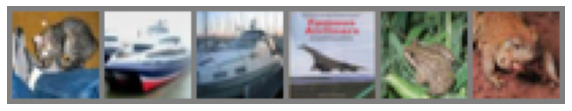

In [ ]:
def plot_images(images) -> None:
    """Plot some images."""
    fig = plt.figure(figsize=(10, 10))
    img = images / 2 + 0.5   
    plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Plot image examples!
plot_images(torchvision.utils.make_grid(x_batch[:6, :, :, :]))

### 1.2 Train a LeNet model

(or any other model of choice). Network architecture and training procedure is partly copied from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(3, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.fc_1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = torch.nn.Linear(120, 84)
        self.fc_3 = torch.nn.Linear(84, 10)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.relu_4 = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x


# Load model architecture.
model = Net()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: Net(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)



In [ ]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if evaluate:
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [ ]:
path_model_weights = path + "/quantus/tutorials/assets/cifar10"

if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
    
else:

    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        train_data=train_loader,
                        test_data=test_loader,
                        device=device,
                        epochs=20,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                        evaluate=True)

    # Save model.
    torch.save(model.state_dict(), path_model_weights)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Model test accuracy: 59.51%


### 1.3 Load gradient-based attributions

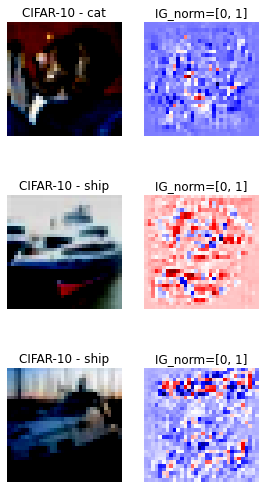

In [ ]:
# Load some attributions and plot them. 
a_batch = quantus.explain(model, 
                          x_batch, 
                          y_batch, 
                          method="IntegratedGradients",
                          **{"normalize": True})

# Plot examplary inputs!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*1.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(np.moveaxis(np.clip(x_batch[i].cpu().numpy(), 0, 1), 0, -1), 
                   vmin=0.0, vmax=1.0)
    axes[i, 0].title.set_text(f"CIFAR-10 - {classes[y_batch[i].item()]}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a_batch[i], cmap="seismic")
    axes[i, 1].title.set_text(f"IG_norm=[0, 1]")
    axes[i, 1].axis("off")
plt.show()

## 2. Quantiatative evaluation using Quantus

### 2.1 Measure sensitivity of hyperparameter choice

We want to understand how sensitive the evaluation outome of Faithfulness Correlation (Bhatt et al., 2020) is from its hyperparameters.

In [ ]:
# Let's list the default parameters of the metric.
metric = quantus.FaithfulnessCorrelation()

WARNINGS.

The Faithfulness correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. 
Go over and select each hyperparameter of the metric carefully to avoid misinterpretation of scores. 
To view all relevant hyperparameters call .get_params of the metric instance. 
For further reading: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



In [ ]:
# Recompute some Saliency explanations.
a_batch = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
a_batch_occ = Occlusion(model).attribute(inputs=x_batch, target=y_batch, sliding_window_shapes=(1, 4, 4)).sum(axis=1).cpu().numpy()
a_batch_ig = IntegratedGradients(model.to(device)).attribute(inputs=x_batch,
                                                             target=y_batch,
                                                             baselines=torch.zeros_like(x_batch), 
                                                             n_steps=10, 
                                                             method="riemann_trapezoid").sum(axis=1).cpu().numpy()
a_batch_gh = GradientShap(model).attribute(inputs=x_batch,
                                           target=y_batch,
                                           baselines=torch.zeros_like(x_batch),).sum(axis=1).cpu().data.numpy()

# Metric class expects numpy arrays.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

In [ ]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "random", "uniform", "black", "white"]
subset_sizes = np.array([ 2,  52, 102])
iterations = [100, 200]
absolutes = [True, False]
normalisations = [True, False]
sim_funcs = {"pearson": quantus.correlation_pearson, "spearman": quantus.correlation_spearman}

In [ ]:
result = {
    "Normalise": [],
    "Absolute": [],
    "Similarity function": [],
    "Faithfulness score": [],
    "Baseline strategy": [],
    "Subset size": [],
    "Method": [],
    "Iterations": [],
}
methods = {"Saliency": a_batch, "Occlusion": a_batch_occ, "Integrated Gradients": a_batch_ig, "GradShap": a_batch_gh}

In [ ]:
#!ls drive/MyDrive/Projects/quantus/tutorials/assets/data

In [ ]:
path_sensitivity_results = "sensitivity_results_200_extra_extra.csv" #"drive/MyDrive/Projects/quantus/tutorials/assets/data/sensitivity_results.csv"

if pathlib.Path(path_sensitivity_results).is_file():
    df = pd.read_csv(path_sensitivity_results)
len(df)

2160

In [ ]:
path_sensitivity_results = path + "/quantus/tutorials/assets/data/sensitivity_results.csv"

if pathlib.Path(path_sensitivity_results).is_file():
    df = pd.read_csv(path_sensitivity_results)

else:

    # Score explanations!
    for b in baseline_strategies:
        for s in subset_sizes:
            for nr in iterations: 
                for method, attr in methods.items():
                    for sim, sim_func in sim_funcs.items():
                            score = np.mean(FaithfulnessCorrelation({'abs': True,
                                                                    'normalize': True,
                                                                    'normalize_func': quantus.normalize_by_max,
                                                                    'nr_runs': nr,
                                                                    'perturb_baseline': b,
                                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                                    'similarity_func': sim_func,
                                                                    'subset_size': s})(model=model.cuda(), 
                                                                                    x_batch=x_batch, 
                                                                                    y_batch=y_batch,
                                                                                    a_batch=attr,
                                                                                    **{"device": device}))
                            
                            result["Method"].append(method)
                            result["Baseline strategy"].append(b.capitalize())
                            result["Subset size"].append(s)
                            result["Iterations"].append(nr)
                            result["Faithfulness score"].append(score)
                            result["Similarity function"].append("spearman")

    
    df = pd.DataFrame(result)
    df["Rank"] = df.groupby(['Baseline strategy', 'Subset size', 'Iterations', 'Similarity function'])["Faithfulness score"].rank()
    df.to_csv(path + "/quantus/tutorials/assets/data/sensitivity_results.csv")

# Smaller adjustments.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.replace(to_replace="Integrated Gradients", value="Integrated\nGradients", inplace=True)
df.replace(value="GradShap", to_replace="GS", inplace=True)
df.columns = map(lambda x: str(x).capitalize(), df.columns)

In [ ]:
path_sensitivity_results = "sensitivity_results_200_extra_extra.csv" #"drive/MyDrive/Projects/quantus/tutorials/assets/data/sensitivity_results.csv"

if pathlib.Path(path_sensitivity_results).is_file():
    df = pd.read_csv(path_sensitivity_results)


# Smaller adjustments.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.replace(to_replace="Integrated Gradients", value="Integrated\nGradients", inplace=True)
df.replace(value="GradShap", to_replace="GS", inplace=True)
df.columns = map(lambda x: str(x).capitalize(), df.columns)

df["Rank_2"] = df.groupby(['Baseline strategy', 'Subset size', 'Iterations', 'Similarity function'])["Faithfulness score"].rank()
df

,Normalise,Absolute,Faithfulness score,Baseline strategy,Subset size,Method,Iterations,Similarity function,Rank,Rank_2
0,True,True,0.029557,Mean,2,Saliency,100,pearson,3.0,7.0
1,True,True,0.018670,Mean,2,Integrated\nGradients,100,pearson,2.0,3.0
2,True,True,0.024692,Mean,2,Saliency,100,spearman,3.0,8.0
3,True,False,0.021572,Mean,2,Integrated\nGradients,100,pearson,3.0,5.0
4,True,False,-0.063219,Mean,2,Saliency,100,spearman,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2155,False,False,0.048248,White,142,Occlusion,500,pearson,3.0,9.0
2156,False,False,0.023836,White,142,Integrated\nGradients,500,pearson,2.0,4.0
2157,False,False,-0.019863,White,142,Saliency,500,spearman,1.0,1.0
2158,False,False,-0.016180,White,142,Occlusion,500,spearman,2.0,2.0


In [ ]:
df.groupby(['Baseline strategy', 'Subset size', 'Iterations', 'Similarity function']).mean()

Normalise  ...  Rank_2
Baseline strategy Subset size Iterations Similarity function             ...        
Black             2           100        pearson                    0.5  ...     6.5
                                         spearman                   0.5  ...     6.5
                              250        pearson                    0.5  ...     6.5
                                         spearman                   0.5  ...     6.5
                              500        pearson                    0.5  ...     6.5
...                                                                 ...  ...     ...
White             142         100        spearman                   0.5  ...     6.5
                              250        pearson                    0.5  ...     6.5
                                         spearman                   0.5  ...     6.5
                              500        pearson                    0.5  ...     6.5
                                         spearman                   0.5  ...     6.5

[180 rows x 5 columns]

In [ ]:
#df["Rank"] = df.groupby(['Baseline strategy', 'Subset size', 'Iterations', 'Similarity function'])["Faithfulness score"].rank()

In [ ]:
# Convert to datafame and rank. 
df = pd.DataFrame(result)
df.to_csv(path + "/quantus/tutorials/assets/data/sensitivity_results.csv")
df["Rank"] = df.groupby(['Baseline strategy', 'Subset size', 'Iterations', 'Similarity function']).rank()

# Write to disk and re-open.
df.to_csv(path + "/quantus/tutorials/assets/data/sensitivity_results.csv")
df = pd.read_csv(path + "/quantus/tutorials/assets/data/sensitivity_results.csv")

# Smaller adjustments.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.replace(to_replace="Integrated Gradients", value="Integrated\nGradients", inplace=True)
df.replace(value="GradShap", to_replace="GS", inplace=True)
df.columns = map(lambda x: str(x).capitalize(), df.columns)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Normalise,Absolute,Faithfulness score,Baseline strategy,Subset size,Method,Iterations,Similarity function,Rank
0,True,True,0.029557,Mean,2,Saliency,100,pearson,7.0
1,True,True,0.018670,Mean,2,Integrated\nGradients,100,pearson,3.0
2,True,True,0.024692,Mean,2,Saliency,100,spearman,8.0
3,True,False,0.021572,Mean,2,Integrated\nGradients,100,pearson,5.0
4,True,False,-0.063219,Mean,2,Saliency,100,spearman,1.0
...,...,...,...,...,...,...,...,...,...
2155,False,False,0.048248,White,142,Occlusion,500,pearson,9.0
2156,False,False,0.023836,White,142,Integrated\nGradients,500,pearson,4.0
2157,False,False,-0.019863,White,142,Saliency,500,spearman,1.0
2158,False,False,-0.016180,White,142,Occlusion,500,spearman,2.0


In [ ]:
# Group by rank
df_view = df.groupby(["Method"])["Rank"].value_counts(normalize=True).mul(100).reset_index(name='Percentage').round(2)
df_view = df_view.append({'Method': 'Method A', 'Rank': 1.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method B', 'Rank': 2.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method C', 'Rank': 3.0, 'Percentage': 100}, ignore_index=True)
#df_view = df_view.append({'Method': 'Method D', 'Rank': 4.0, 'Percentage': 100}, ignore_index=True)

# Reorder the methods for plotting purporses.
df_view_ordered = pd.DataFrame(columns=["Method", "Rank", "Percentage"])
df_view_ordered = df_view_ordered.append({'Method': 'Method A', 'Rank': 1.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method B', 'Rank': 2.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method C', 'Rank': 3.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method D', 'Rank': 4.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Saliency']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Occlusion']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Integrated\nGradients']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'GradShap']], ignore_index=True)
df_view_ordered

### 2.2 Plot results!

In [ ]:
plt.style.use('seaborn-white')
sns.set(font_scale=1.5)

path = "drive/MyDrive/Projects/"

In [ ]:
# Plot 1!

fig, ax = plt.subplots(figsize=(6.5,5))
ax = sns.histplot(x='Method', hue='Rank', weights='Percentage', multiple='stack', data=df_view_ordered, shrink=0.6, palette="colorblind", legend=False)
ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Frequency of rank')
ax.set_xlabel('')
ax.set_xticklabels(["A", "B", "C", "D", "SAL", "OCC", "IG", "GD"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False, labels=['1st', "2nd", "3rd", "4th"])
plt.axvline(x=2.5, ymax=0.95, color='black', linestyle='-')
plt.tight_layout()
plt.savefig(f'{path}sensitivity_analysis_1.png', dpi = 400)

In [ ]:
# Plot 2!

ax = sns.catplot(x="Baseline strategy", y="Rank", hue="Method", kind="bar", estimator=np.mean, hue_order=['SAL', 'OCC', 'IG', "GD"],
                 data=df, palette=sns.color_palette("husl", 3), legend=False, height=5, aspect=7.5/5.8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False)
ax.set_ylabels('Mean Rank')
ax.set_xlabels('')
plt.tight_layout()
plt.savefig(f'{path}sensitivity_analysis_2.png', dpi = 400)

In [ ]:
# Plot 3!
df_subset = df.loc[(df["Iterations"] == 100) & (df["Subset size"] == 102) & (df["Similarity function"] == "spearman")]
ax = sns.catplot(x="Baseline strategy", y="Rank", hue="Method", kind="bar", estimator=np.mean, hue_order=['Saliency', 'Occlusion', 'Integrated\nGradients'],
                 data=df_subset, palette=sns.color_palette("husl", 3), legend=False) 
ax.set_xlabels('')
ax.set_ylabels('')
plt.legend(handles=["", "", ""], labels=["", "", ""], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.show()